# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


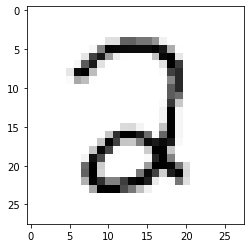

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2505
Training Accuracy: 0.4963, Testing Accuracy: 0.5015



Epoch 10, Loss 0.2251
Training Accuracy: 0.8258, Testing Accuracy: 0.8347



Epoch 20, Loss 0.1439
Training Accuracy: 0.8897, Testing Accuracy: 0.8992



Epoch 30, Loss 0.0756
Training Accuracy: 0.9243, Testing Accuracy: 0.9365



Epoch 40, Loss 0.0542
Training Accuracy: 0.9421, Testing Accuracy: 0.9511



Epoch 50, Loss 0.0449
Training Accuracy: 0.9496, Testing Accuracy: 0.9597



Epoch 60, Loss 0.0397
Training Accuracy: 0.9543, Testing Accuracy: 0.9622



Epoch 70, Loss 0.0364
Training Accuracy: 0.9578, Testing Accuracy: 0.9662



Epoch 80, Loss 0.0341
Training Accuracy: 0.9592, Testing Accuracy: 0.9657



Epoch 90, Loss 0.0324
Training Accuracy: 0.9608, Testing Accuracy: 0.9677



Epoch 100, Loss 0.0309
Training Accuracy: 0.9626, Testing Accuracy: 0.9693



Epoch 110, Loss 0.0298
Training Accuracy: 0.9640, Testing Accuracy: 0.9698



Epoch 120, Loss 0.0288
Training Accuracy: 0.9655, Testing Accuracy: 0.9703



Epoch 130, Loss 0.0279
Training Accuracy: 0.9665, Testing Accuracy: 0.9708



Epoch 140, Loss 0.0272
Training Accuracy: 0.9675, Testing Accuracy: 0.9693



Epoch 150, Loss 0.0265
Training Accuracy: 0.9685, Testing Accuracy: 0.9698



Epoch 160, Loss 0.0259
Training Accuracy: 0.9693, Testing Accuracy: 0.9703



Epoch 170, Loss 0.0253
Training Accuracy: 0.9700, Testing Accuracy: 0.9708



Epoch 180, Loss 0.0248
Training Accuracy: 0.9710, Testing Accuracy: 0.9713



Epoch 190, Loss 0.0243
Training Accuracy: 0.9713, Testing Accuracy: 0.9718



Epoch 200, Loss 0.0239
Training Accuracy: 0.9718, Testing Accuracy: 0.9713



Epoch 210, Loss 0.0235
Training Accuracy: 0.9724, Testing Accuracy: 0.9718



Epoch 220, Loss 0.0231
Training Accuracy: 0.9730, Testing Accuracy: 0.9718



Epoch 230, Loss 0.0227
Training Accuracy: 0.9730, Testing Accuracy: 0.9723



Epoch 240, Loss 0.0223
Training Accuracy: 0.9737, Testing Accuracy: 0.9728



0.051489283569492436

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2102
Training Accuracy: 0.7772, Testing Accuracy: 0.7979



Epoch 10, Loss 0.0998
Training Accuracy: 0.9098, Testing Accuracy: 0.9194



Epoch 20, Loss 0.0776
Training Accuracy: 0.9279, Testing Accuracy: 0.9461



Epoch 30, Loss 0.0671
Training Accuracy: 0.9370, Testing Accuracy: 0.9516



Epoch 40, Loss 0.0608
Training Accuracy: 0.9422, Testing Accuracy: 0.9526



Epoch 50, Loss 0.0564
Training Accuracy: 0.9452, Testing Accuracy: 0.9536



Epoch 60, Loss 0.0532
Training Accuracy: 0.9473, Testing Accuracy: 0.9561



Epoch 70, Loss 0.0507
Training Accuracy: 0.9498, Testing Accuracy: 0.9572



Epoch 80, Loss 0.0487
Training Accuracy: 0.9516, Testing Accuracy: 0.9592



Epoch 90, Loss 0.047
Training Accuracy: 0.9520, Testing Accuracy: 0.9612



Epoch 100, Loss 0.0456
Training Accuracy: 0.9529, Testing Accuracy: 0.9627



Epoch 110, Loss 0.0444
Training Accuracy: 0.9540, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0434
Training Accuracy: 0.9553, Testing Accuracy: 0.9637



Epoch 130, Loss 0.0425
Training Accuracy: 0.9559, Testing Accuracy: 0.9652



Epoch 140, Loss 0.0417
Training Accuracy: 0.9563, Testing Accuracy: 0.9652



Epoch 150, Loss 0.0409
Training Accuracy: 0.9566, Testing Accuracy: 0.9662



Epoch 160, Loss 0.0403
Training Accuracy: 0.9573, Testing Accuracy: 0.9667



Epoch 170, Loss 0.0397
Training Accuracy: 0.9581, Testing Accuracy: 0.9667



Epoch 180, Loss 0.0391
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 190, Loss 0.0386
Training Accuracy: 0.9594, Testing Accuracy: 0.9667



Epoch 200, Loss 0.0382
Training Accuracy: 0.9597, Testing Accuracy: 0.9667



Epoch 210, Loss 0.0377
Training Accuracy: 0.9599, Testing Accuracy: 0.9657



Epoch 220, Loss 0.0373
Training Accuracy: 0.9599, Testing Accuracy: 0.9672



Epoch 230, Loss 0.0369
Training Accuracy: 0.9599, Testing Accuracy: 0.9677



Epoch 240, Loss 0.0366
Training Accuracy: 0.9608, Testing Accuracy: 0.9682



0.029183240645747562

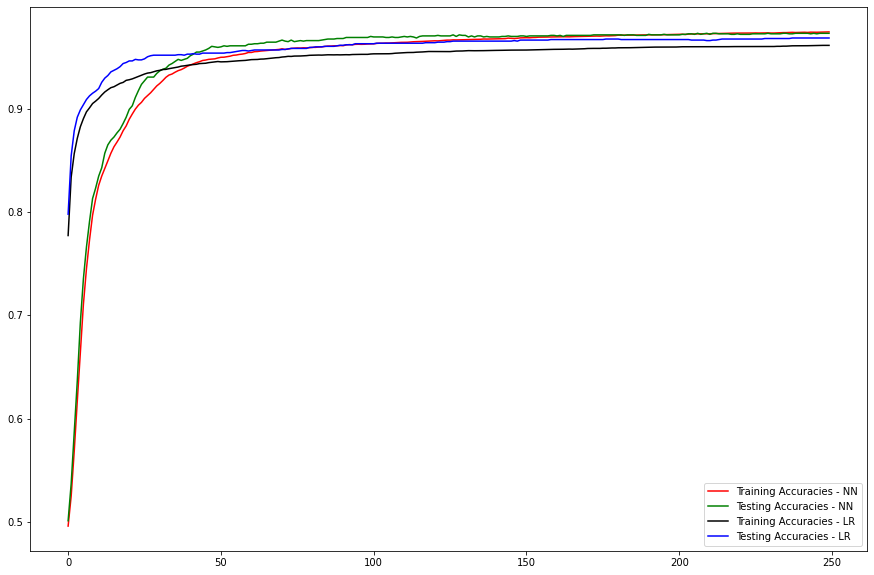

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

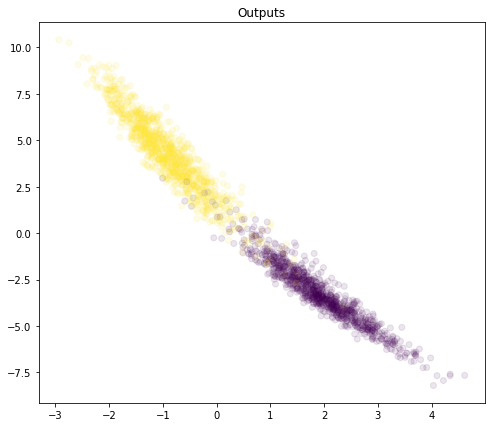

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

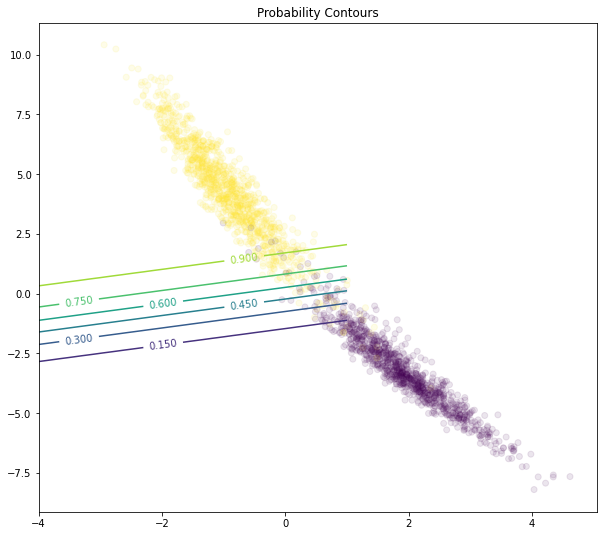

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );